# Melanoma Detection Dataset

##### Labeled images of melanoma, nevus and seborrheic keratosis
\


\
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

Luca Porcelli, Valentina Barbera, Vittorio Haardt

In [ ]:
!PYTHONHASHSEED=0

In [ ]:
# Import TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.12.0'

In [ ]:
# Import other modules
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import seaborn as sns
import random as python_random
from sklearn.utils import class_weight
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image as im
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.inception_v3 import preprocess_input
from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net
import os
import random

In [ ]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

In [ ]:
# Settings for prettier visualization in Google Colab
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# Data management

### Dataset download

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


### Data loader

In [ ]:
#base_path = 'gdrive/My Drive/Progetto DeepLearning/Data/'

<IPython.core.display.Javascript object>

In [ ]:
import os
import random
from shutil import copyfile

# Definisci i percorsi delle cartelle originali e di destinazione per il sottocampionamento
original_data_dir = 'gdrive/My Drive/Progetto DeepLearning/Data/'
subsampled_data_dir = 'gdrive/My Drive/Progetto DeepLearning/ppp/'

# Definisci il numero desiderato di campioni per classe nel set di dati sottocampionato
min_class_count = min(
    len(os.listdir(os.path.join(original_data_dir, 'melanoma'))),
    len(os.listdir(os.path.join(original_data_dir, 'nevus'))),
    len(os.listdir(os.path.join(original_data_dir, 'seborrheic_keratosis')))
)

# Esegui il sottocampionamento per ogni classe
for class_label in ['melanoma', 'nevus', 'seborrheic_keratosis']:
    class_folder = os.path.join(original_data_dir, class_label)
    subsampled_class_folder = os.path.join(subsampled_data_dir, class_label)
    os.makedirs(subsampled_class_folder, exist_ok=True)

    # Prendi un numero casuale di campioni da ciascuna classe
    samples = random.sample(os.listdir(class_folder), min_class_count)

    # Copia i campioni selezionati nella cartella sottocampionata
    for sample in samples:
        src = os.path.join(class_folder, sample)
        dst = os.path.join(subsampled_class_folder, sample)
        copyfile(src, dst)

print("Dimensioni originali del set di dati:", len(os.listdir(os.path.join(original_data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(original_data_dir, 'nevus'))),
      len(os.listdir(os.path.join(original_data_dir, 'seborrheic_keratosis'))))

print("Dimensioni del set di dati sottocampionato:", len(os.listdir(os.path.join(subsampled_data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'nevus'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'seborrheic_keratosis'))))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dimensioni originali del set di dati: 521 1843 386
Dimensioni del set di dati sottocampionato: 386 386 386


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'gdrive/My Drive/Progetto DeepLearning/Data/seborrheic_keratosis'

In [ ]:

import os
import random
from shutil import copyfile

# Define the paths of the original data folder and the subsampled data folder
original_data_dir = 'gdrive/My Drive/Progetto DeepLearning/Data/'
subsampled_data_dir = 'gdrive/My Drive/Progetto DeepLearning/p/'

# Define the percentage of samples to be selected from each class
percentage = 0.4

# Perform subsampling for each class
for class_label in ['melanoma', 'nevus', 'seborrheic_keratosis']:
    class_folder = os.path.join(original_data_dir, class_label)
    subsampled_class_folder = os.path.join(subsampled_data_dir, class_label)
    os.makedirs(subsampled_class_folder, exist_ok=True)

    # Get the list of samples in the class folder
    samples = os.listdir(class_folder)

    # Calculate the number of samples to be selected based on the percentage
    num_samples = int(len(samples) * percentage)

    # Randomly select the specified number of samples
    selected_samples = random.sample(samples, num_samples)

    # Copy the selected samples to the subsampled class folder
    for sample in selected_samples:
        src = os.path.join(class_folder, sample)
        dst = os.path.join(subsampled_class_folder, sample)
        copyfile(src, dst)

print("Original dataset sizes:", len(os.listdir(os.path.join(original_data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(original_data_dir, 'nevus'))),
      len(os.listdir(os.path.join(original_data_dir, 'seborrheic_keratosis'))))

print("Subsampled dataset sizes:", len(os.listdir(os.path.join(subsampled_data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'nevus'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'seborrheic_keratosis'))))


<IPython.core.display.Javascript object>

Original dataset sizes: 521 1843 386
Subsampled dataset sizes: 208 737 154


Distribuzione classi:
* Melanoma = 19%
* Nevus=67%
* Seborrheic keratosis=14%

In [ ]:
'''
import os
import random
from keras.preprocessing.image import ImageDataGenerator
import shutil

# Definisci il percorso della cartella originale contenente le immagini divise per classe
data_dir = 'gdrive/My Drive/Progetto DeepLearning/Data/'

# Definisci il percorso della cartella di destinazione per il set di dati sottocampionato
subsampled_data_dir = 'gdrive/My Drive/Progetto DeepLearning/pesi/'

# Definisci i pesi associati a ciascuna classe
class_weights = {
    'melanoma': 1.1396304921164924,
    'seborrheic_keratosis': 1.5382059232971308,
    'nevus':0.32216358458637684
}

# Crea un generatore di immagini per il set di dati originale
datagen = ImageDataGenerator(rescale=1./255)

# Genera un flusso di immagini dal set di dati originale
flow_from_directory_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

# Esegui il sottocampionamento utilizzando il generatore di immagini
for class_label in flow_from_directory_generator.class_indices:
    class_folder = os.path.join(data_dir, class_label)
    subsampled_class_folder = os.path.join(subsampled_data_dir, class_label)
    os.makedirs(subsampled_class_folder, exist_ok=True)

    # Calcola il numero di campioni da selezionare in base ai pesi
    num_samples = int(class_weights[class_label] * len(os.listdir(class_folder)))

    # Prendi un numero casuale di campioni dalla classe in base al numero calcolato e ai pesi
    samples = random.choices(os.listdir(class_folder), k=num_samples, weights=[1] * len(os.listdir(class_folder)))

    # Copia i campioni selezionati nella cartella sottocampionata
    for sample in samples:
        src = os.path.join(class_folder, sample)
        dst = os.path.join(subsampled_class_folder, sample)
        shutil.copy(src, dst)
'''

<IPython.core.display.Javascript object>

"\nimport os\nimport random\nfrom keras.preprocessing.image import ImageDataGenerator\nimport shutil\n\n# Definisci il percorso della cartella originale contenente le immagini divise per classe\ndata_dir = 'gdrive/My Drive/Progetto DeepLearning/Data/'\n\n# Definisci il percorso della cartella di destinazione per il set di dati sottocampionato\nsubsampled_data_dir = 'gdrive/My Drive/Progetto DeepLearning/pesi/'\n\n# Definisci i pesi associati a ciascuna classe\nclass_weights = {\n    'melanoma': 1.1396304921164924,\n    'seborrheic_keratosis': 1.5382059232971308,\n    'nevus':0.32216358458637684\n}\n\n# Crea un generatore di immagini per il set di dati originale\ndatagen = ImageDataGenerator(rescale=1./255)\n\n# Genera un flusso di immagini dal set di dati originale\nflow_from_directory_generator = datagen.flow_from_directory(\n    data_dir,\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='categorical',\n    shuffle=True,\n    seed=123\n)\n\n# Esegui il sottocampionamen

In [ ]:
'''
print("Original dataset sizes:", len(os.listdir(os.path.join(data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(data_dir, 'nevus'))),
      len(os.listdir(os.path.join(data_dir, 'seborrheic_keratosis'))))

print("Subsampled dataset sizes:", len(os.listdir(os.path.join(subsampled_data_dir, 'melanoma'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'nevus'))),
      len(os.listdir(os.path.join(subsampled_data_dir, 'seborrheic_keratosis'))))
'''

<IPython.core.display.Javascript object>

'\nprint("Original dataset sizes:", len(os.listdir(os.path.join(data_dir, \'melanoma\'))),\n      len(os.listdir(os.path.join(data_dir, \'nevus\'))),\n      len(os.listdir(os.path.join(data_dir, \'seborrheic_keratosis\'))))\n\nprint("Subsampled dataset sizes:", len(os.listdir(os.path.join(subsampled_data_dir, \'melanoma\'))),\n      len(os.listdir(os.path.join(subsampled_data_dir, \'nevus\'))),\n      len(os.listdir(os.path.join(subsampled_data_dir, \'seborrheic_keratosis\'))))\n'

### Training and Validation set

In [ ]:
subsampled_data_dir = 'gdrive/My Drive/Progetto DeepLearning/p/'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(subsampled_data_dir ,# Directory containing the image dataset
                                                                 image_size=(224, 224),# Desired size of the input images
                                                                 batch_size=32,# Number of samples per batch
                                                                 label_mode='categorical',# Encoding labels as one-hot vectors
                                                                 subset='training',# Subset of data to use for training
                                                                 validation_split=0.2,# Percentage of data to use for validation
                                                                 shuffle=True,# Shuffle the data
                                                                 seed=123# Random seed for reproducibility
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 1099 files belonging to 3 classes.
Using 880 files for training.


In [ ]:
train_dataset.class_names

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['melanoma', 'nevus', 'seborrheic_keratosis']

A data loader take care of the following tasks:
* Loading input and target data
*splitting the dataset into mini batches

The `image_dataset_from_directory` function expects a folder with as many subfolders as the number of classes. Inside each subfolder, all the images of that specific class.

Data shuffling (randomization of the instances order) is fundamental in order to ensure that each minibatch is representative of the whole set of classes (or as many classes as possible)

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(subsampled_data_dir ,# Directory containing the image dataset
                                                               image_size=(224, 224),# Desired size of the input images
                                                               batch_size=32,# Number of samples per batch
                                                               label_mode='categorical',# Encoding labels as one-hot vectors
                                                               subset='validation',# Subset of data to use for validation
                                                               validation_split=0.2,# Percentage of data to use for validation
                                                               shuffle=True,# Shuffle the data
                                                               seed=123# Random seed for reproducibility
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 1099 files belonging to 3 classes.
Using 219 files for validation.


### Weight setting

In [ ]:
import os
import numpy as np

def calculate_class_weights(data_dir):
    class_weights = {}
    label_indices = {}
    index = 0

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            num_images = len(os.listdir(label_dir))  # Conta il numero di immagini nella cartella
            class_weights[index] = 1 / num_images  # Calcola il peso della classe come l'inverso del numero di immagini
            label_indices[label] = index  # Memorizza l'indice corrente associato al label nella mappa
            index += 1  # Incrementa l'indice corrente.

    # Calcola i pesi normalizzati (somma totale = 1) dividendo ogni peso di classe per la somma di tutti i pesi e moltiplicando per il numero totale di classi.
    total_sum = sum(class_weights.values())
    class_weights_normalized = {label: weight / total_sum for label, weight in class_weights.items()}

    return class_weights_normalized

train_class_weights = calculate_class_weights(subsampled_data_dir)
train_class_weights


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{0: 0.37981300154605024, 1: 0.10719281454759626, 2: 0.5129941839063535}

In [ ]:
os.listdir(subsampled_data_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['melanoma', 'nevus', 'seborrheic_keratosis']

In the following code we obtain the weight of each class in the training dataset. We can see that the seborrheic_keratosis is the class with higher weight, this mean taht is the class characterize with large number of observations.  

# Defining a model

In [ ]:
num_classes = 3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Defining a model Without balancing

### Model 1

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, and "same" padding
x = keras.layers.Conv2D(32, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters and a kernel size of 3x3
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Creating the model with the defined inputs and outputs
net1_without_balancing = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

* `Conv2D()` is the building block of convolutional neural networks, applies a convolutional kernel to each pixel neighborhood.
* `MaxPooling2D()` replaces each pixel neighborhood with its maximum value.
* `GlobalAveragePooling2D()` applies max pooling to all pixels (still treating each channel independently).
* `Activation()` applies a per-pixel non-linear function to the input, increasing the representation complexity.
* `Dense()` creates a fully-connected layer mapping:<br/> from the number of elements that are given as input <u>to the layer</u> (defined implicitly)<br/> to the number of specified elements (3 in our case, provided as the first argument)

*   The `softmax` function is used at the end of classification models. It serves two purposes:
     1. Set the sum of elements to be 1, so that they represent a probability distribution.
     2. Distorce the differences between values in the distribution (but preserving the rank relation).

In [ ]:
# Compile the model for training
net1_without_balancing.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.SparseCategoricalAccuracy()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* The `Optimizer` is the RMProp :
  1. Keep track of an average of the squared gradients.
  2. Divide each gradient by the square root of this average.

In [ ]:
# Model training (v1)
history1_without_balancing = net1_without_balancing.fit(train_dataset,
          epochs=2,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/2


ValueError: ignored

In [ ]:
import plotly.graph_objects as go

# Grafico della loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['loss']) + 1)),
    y=history1_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['val_loss']) + 1)),
    y=history1_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

'gdrive/My Drive/Progetto DeepLearning/Imm/Compare/loss_plot_1.png'

# Grafico dell'accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['accuracy']) + 1)),
    y=history1_without_balancing.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['val_accuracy']) + 1)),
    y=history1_without_balancing.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['precision']) + 1)),
    y=history1_without_balancing.history['precision'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_without_balancing.history['val_precision']) + 1)),
    y=history1_without_balancing.history['val_precision'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


<IPython.core.display.Javascript object>

KeyError: ignored

In [ ]:
net1_without_balancing.evaluate(val_dataset)

<IPython.core.display.Javascript object>

8/8 [==============================] - 40s 498ms/step - loss: 1.5131 - categorical_accuracy: 0.4805 - recall: 0.2954 - precision: 1.0000 - f1_score: 0.4553


[1.5131025314331055,
 0.48051947355270386,
 0.2953869104385376,
 1.0,
 0.4553062319755554]

In [ ]:
# Inference
yc_pred = net1_without_balancing.predict(val_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)
print('Prediction shape (argmax):', y_pred.shape)
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

<IPython.core.display.Javascript object>

8/8 [==============================] - 37s 670ms/step
Prediction shape (probability distribution): (231, 3)
Prediction shape (argmax): (231,)


<IPython.core.display.Javascript object>

8/8 [==============================] - 36s 636ms/step


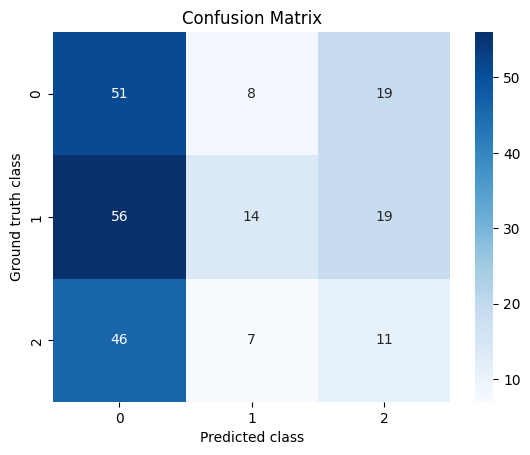

In [ ]:
yc_pred = net1_without_balancing.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calcolo della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Creazione della matrice di confusione
#plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/CM/confusion_matrix_1.png')
plt.show()

In [ ]:
net1_without_balancing.save('gdrive/My Drive/Progetto DeepLearning/Model/net1_without_balancing.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 128 filters, kernel size of 3x3, "same" padding, and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with 64 units, "relu" activation, and L2 regularization with a factor of 0.001
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Adding a final fully connected layer with num_classes units, softmax activation, and L2 regularization with a factor of 0.001
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Creating the model with the defined inputs and outputs
net2_without_balancing = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

* L2 regularization strategy also known as Ridge Regression. Is also commonly known as weight decay. This strategy drives the weights closer to the origin by adding a regularization term to the objective function.

* Batch Normalization : it is a method of adaptive reparameterization, motivated by the difficulty of training very deep models,through normalization of the layers inputs by re-centering and re-scaling.

In [ ]:
# Compile the model for training
net2_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history2_without_balancing = net2_without_balancing.fit(train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/100
29/29 [==============================] - 265s 8s/step - loss: 1.7009 - accuracy: 0.4585 - precision_1: 0.4660 - val_loss: 1.4023 - val_accuracy: 0.3939 - val_precision_1: 0.4173
Epoch 2/100
29/29 [==============================] - 260s 8s/step - loss: 1.1865 - accuracy: 0.5254 - precision_1: 0.5660 - val_loss: 1.3529 - val_accuracy: 0.4372 - val_precision_1: 0.4662
Epoch 3/100
29/29 [==============================] - 253s 7s/step - loss: 1.1216 - accuracy: 0.5674 - precision_1: 0.6175 - val_loss: 1.4259 - val_accuracy: 0.4632 - val_precision_1: 0.4916
Epoch 4/100
29/29 [==============================] - 267s 8s/step - loss: 1.0894 - accuracy: 0.5707 - precision_1: 0.6174 - val_loss: 1.2158 - val_accuracy: 0.4805 - val_precision_1: 0.5169
Epoch 5/100
29/29 [==============================] - 261s 8s/step - loss: 1.0258 - accuracy: 0.6106 - precision_1: 0.6657 - val_loss: 1.4064 - val_accuracy: 0.5108 - val_precision_1: 0.5120
Epoch 6/100
29/29 [==============================]

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['loss']) + 1)),
    y=history2_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['val_loss']) + 1)),
    y=history2_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['accuracy']) + 1)),
    y=history2_without_balancing.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['val_accuracy']) + 1)),
    y=history2_without_balancing.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['precision_1']) + 1)),
    y=history2_without_balancing.history['precision_1'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_without_balancing.history['val_precision_1']) + 1)),
    y=history2_without_balancing.history['val_precision_1'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net2_without_balancing.evaluate(val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8/8 [==============================] - 41s 786ms/step - loss: 1.1814 - accuracy: 0.5541 - precision_1: 0.5687


[1.1813939809799194, 0.5541125535964966, 0.5687204003334045]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8/8 [==============================] - 34s 989ms/step


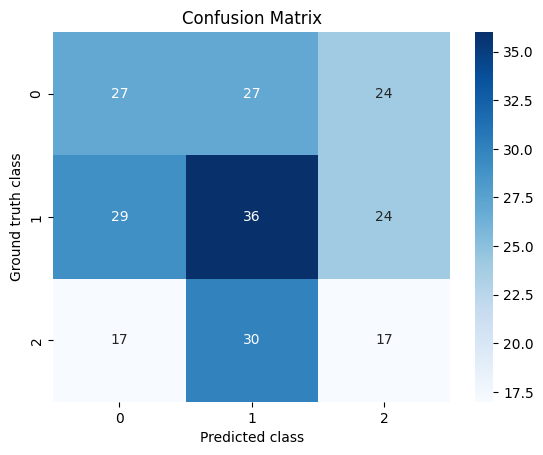

In [ ]:
yc_pred = net2_without_balancing.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/CM/confusion_matrix_2.png')
plt.show()

In [ ]:
net2_without_balancing.save('gdrive/My Drive/Progetto DeepLearning/Model/net2_without_balancing.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 3

In [ ]:
# Base model

# Using the pre-trained ResNet50 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of ResNet50
x = keras.applications.resnet50.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net3_without_balancing = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compile the model for training
net3_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history3_without_balancing = net3_without_balancing.fit(train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/100
29/29 [==============================] - 400s 12s/step - loss: 12.9381 - accuracy: 0.4887 - precision_2: 0.4908 - val_loss: 4.3407 - val_accuracy: 0.5455 - val_precision_2: 0.5502
Epoch 2/100
29/29 [==============================] - 399s 12s/step - loss: 3.9764 - accuracy: 0.6257 - precision_2: 0.6270 - val_loss: 7.3775 - val_accuracy: 0.4935 - val_precision_2: 0.4913
Epoch 3/100
29/29 [==============================] - 395s 12s/step - loss: 1.5446 - accuracy: 0.8037 - precision_2: 0.8035 - val_loss: 4.6577 - val_accuracy: 0.5714 - val_precision_2: 0.5739
Epoch 4/100
29/29 [==============================] - 389s 12s/step - loss: 1.9651 - accuracy: 0.7972 - precision_2: 0.7970 - val_loss: 8.5794 - val_accuracy: 0.5411 - val_precision_2: 0.5411
Epoch 5/100
29/29 [==============================] - 396s 12s/step - loss: 1.2320 - accuracy: 0.8598 - precision_2: 0.8598 - val_loss: 3.5549 - val_accuracy: 0.6017 - val_precision_2: 0.6079
Epoch 6/100
29/29 [=========================

KeyboardInterrupt: ignored

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['loss']) + 1)),
    y=history3_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['val_loss']) + 1)),
    y=history3_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['accuracy']) + 1)),
    y=history3_without_balancing.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['val_accuracy']) + 1)),
    y=history3_without_balancing.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['precision_2']) + 1)),
    y=history3_without_balancing.history['precision_2'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_without_balancing.history['val_precision_2']) + 1)),
    y=history3_without_balancing.history['val_precision_2'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


In [ ]:
net3_without_balancing.evaluate(val_dataset)

<IPython.core.display.Javascript object>

4/4 [==============================] - 13s 91ms/step - loss: 4.8671 - accuracy: 0.6514 - precision_2: 0.6514


[4.867064952850342, 0.6513761281967163, 0.6513761281967163]

<IPython.core.display.Javascript object>

4/4 [==============================] - 13s 108ms/step


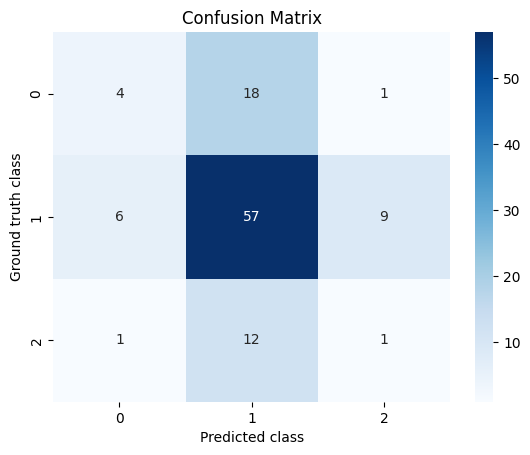

In [ ]:
yc_pred = net3_without_balancing.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/CM/confusion_matrix_3.png')
plt.show()

In [ ]:
net3_without_balancing.save('gdrive/My Drive/Progetto DeepLearning/Model/net3_without_balancing.h5')

<IPython.core.display.Javascript object>

### Model 4

In [ ]:
# Base model

# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_without_balancing = keras.Model(inputs=inputs, outputs=outputs)

<IPython.core.display.Javascript object>

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Compile the model for training
net4_without_balancing.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history4_without_balancing = net4_without_balancing.fit(train_dataset,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/100
14/14 [==============================] - 138s 6s/step - loss: 6.7627 - accuracy: 0.5773 - precision_1: 0.5828 - val_loss: 2.1280 - val_accuracy: 0.6606 - val_precision_1: 0.6606
Epoch 2/100
14/14 [==============================] - 120s 6s/step - loss: 0.7890 - accuracy: 0.7568 - precision_1: 0.7632 - val_loss: 1.5974 - val_accuracy: 0.6881 - val_precision_1: 0.6944
Epoch 3/100
14/14 [==============================] - 96s 5s/step - loss: 0.1624 - accuracy: 0.9341 - precision_1: 0.9356 - val_loss: 1.2305 - val_accuracy: 0.6422 - val_precision_1: 0.6481
Epoch 4/100
14/14 [==============================] - 97s 5s/step - loss: 0.0641 - accuracy: 0.9864 - precision_1: 0.9863 - val_loss: 1.3124 - val_accuracy: 0.6789 - val_precision_1: 0.6729
Epoch 5/100
14/14 [==============================] - 122s 7s/step - loss: 0.1875 - accuracy: 0.9455 - precision_1: 0.9476 - val_loss: 1.6378 - val_accuracy: 0.4220 - val_precision_1: 0.4340
Epoch 6/100
14/14 [==============================] -

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['loss']) + 1)),
    y=history4_without_balancing.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['val_loss']) + 1)),
    y=history4_without_balancing.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['accuracy']) + 1)),
    y=history4_without_balancing.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['val_accuracy']) + 1)),
    y=history4_without_balancing.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['precision_1']) + 1)),
    y=history4_without_balancing.history['precision_1'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_without_balancing.history['val_precision_1']) + 1)),
    y=history4_without_balancing.history['val_precision_1'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net4_without_balancing.evaluate(val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 19s 1s/step - loss: 1.9690 - accuracy: 0.6881 - precision_1: 0.6881


[1.969001054763794, 0.6880733966827393, 0.6880733966827393]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 20s 1s/step


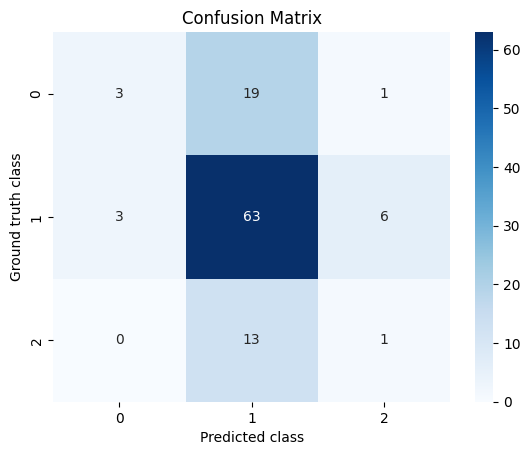

In [ ]:
yc_pred = net4_without_balancing.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/CM/confusion_matrix_4.png')
plt.show()

In [ ]:
net4_without_balancing.save('gdrive/My Drive/Progetto DeepLearning/Model/net4_without_balancing.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Defining a model With weight correction

### Model 1

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, and "same" padding
x = keras.layers.Conv2D(32, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters and a kernel size of 3x3
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Creating the model with the defined inputs and outputs
net1_weight_correction = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

In [ ]:
# Compile the model for training
net1_weight_correction.compile(loss=keras.losses.categorical_crossentropy, #Computes the crossentropy loss between the labels and predictions.
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history1_weight_correction = net1_weight_correction.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
28/28 [==============================] - 238s 7s/step - loss: 5.5737 - accuracy: 0.3636 - precision: 0.3636 - val_loss: 4.9547 - val_accuracy: 0.6712 - val_precision: 0.6712
Epoch 2/100
28/28 [==============================] - 234s 7s/step - loss: 2.2218 - accuracy: 0.3511 - precision: 0.3523 - val_loss: 20.3521 - val_accuracy: 0.1781 - val_precision: 0.1781
Epoch 3/100
28/28 [==============================] - 236s 7s/step - loss: 1.3683 - accuracy: 0.3977 - precision: 0.3975 - val_loss: 13.2044 - val_accuracy: 0.1918 - val_precision: 0.1918
Epoch 4/100
28/28 [==============================] - 232s 7s/step - loss: 0.9412 - accuracy: 0.4182 - precision: 0.4184 - val_loss: 2.6202 - val_accuracy: 0.6712 - val_precision: 0.6712
Epoch 5/100
28/28 [==============================] - 233s 7s/step - loss: 0.7331 - accuracy: 0.4216 - precision: 0.4216 - val_loss: 1.4524 - val_accuracy: 0.5205 - val_precision: 0.5278
Epoch 6/100
28/28 [==============================] - 236s 7s/step - 

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['loss']) + 1)),
    y=history1_weight_correction.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['val_loss']) + 1)),
    y=history1_weight_correction.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['accuracy']) + 1)),
    y=history1_weight_correction.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['val_accuracy']) + 1)),
    y=history1_weight_correction.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['precision_3']) + 1)),
    y=history1_weight_correction.history['precision_3'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_weight_correction.history['val_precision_3']) + 1)),
    y=history1_weight_correction.history['val_precision_3'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net1_weight_correction.evaluate(val_dataset)

<IPython.core.display.Javascript object>

7/7 [==============================] - 30s 560ms/step - loss: 1.3391 - accuracy: 0.5890 - precision: 0.5962


[1.3390785455703735, 0.5890411138534546, 0.5962441563606262]

<IPython.core.display.Javascript object>

7/7 [==============================] - 37s 552ms/step


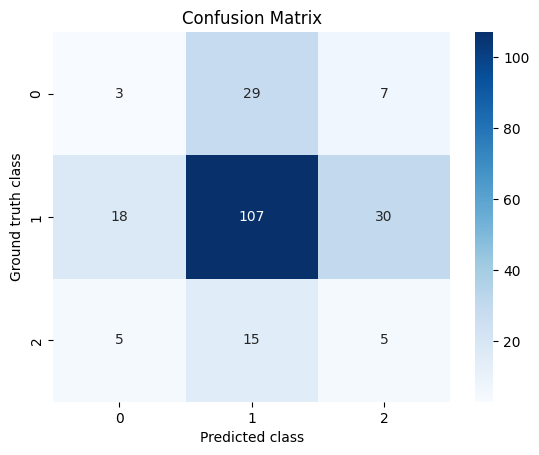

In [ ]:
yc_pred = net1_weight_correction.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Weight_CM/confusion_matrix_1.png')
plt.show()

In [ ]:
net1_weight_correction.save('gdrive/My Drive/Progetto DeepLearning/Model/net1_weight_correction.h5')

<IPython.core.display.Javascript object>

### Model 2

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Adding a convolutional layer with 32 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 128 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with 64 units, "relu" activation,
# and L2 regularization with a factor of 0.001
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Adding a final fully connected layer with num_classes units, softmax activation,
# and L2 regularization with a factor of 0.001
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Creating the model with the defined inputs and outputs
net2_weight_correction = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

In [ ]:
# Compile the model for training
net2_weight_correction.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history2_weight_correction = net2_weight_correction.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
28/28 [==============================] - 138s 3s/step - loss: 0.5453 - accuracy: 0.4295 - precision: 0.4478 - val_loss: 5.6547 - val_accuracy: 0.1142 - val_precision: 0.1142
Epoch 2/100
28/28 [==============================] - 132s 4s/step - loss: 0.4344 - accuracy: 0.4898 - precision: 0.5281 - val_loss: 4.8241 - val_accuracy: 0.1142 - val_precision: 0.1142
Epoch 3/100
28/28 [==============================] - 131s 4s/step - loss: 0.3952 - accuracy: 0.5216 - precision: 0.5577 - val_loss: 1.2708 - val_accuracy: 0.6210 - val_precision: 0.6286
Epoch 4/100
28/28 [==============================] - 131s 4s/step - loss: 0.3806 - accuracy: 0.5432 - precision: 0.5875 - val_loss: 1.4262 - val_accuracy: 0.5388 - val_precision: 0.5349
Epoch 5/100
28/28 [==============================] - 149s 4s/step - loss: 0.3536 - accuracy: 0.5511 - precision: 0.6068 - val_loss: 1.0499 - val_accuracy: 0.6484 - val_precision: 0.6667
Epoch 6/100
28/28 [==============================] - 132s 4s/step - lo

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['loss']) + 1)),
    y=history2_weight_correction.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['val_loss']) + 1)),
    y=history2_weight_correction.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['accuracy']) + 1)),
    y=history2_weight_correction.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['val_accuracy']) + 1)),
    y=history2_weight_correction.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['precision_4']) + 1)),
    y=history2_weight_correction.history['precision_4'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_weight_correction.history['val_precision_4']) + 1)),
    y=history2_weight_correction.history['val_precision_4'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net2_weight_correction.evaluate(val_dataset)

<IPython.core.display.Javascript object>

7/7 [==============================] - 37s 28ms/step - loss: 0.8889 - accuracy: 0.7260 - precision: 0.7366


[0.8889209032058716, 0.7260273694992065, 0.7365853786468506]

<IPython.core.display.Javascript object>

7/7 [==============================] - 23s 24ms/step


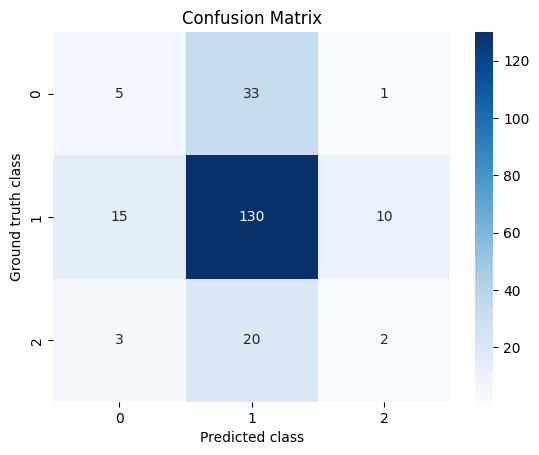

In [ ]:
yc_pred = net2_weight_correction.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Weight_CM/confusion_matrix_2.png')
plt.show()

In [ ]:
net2_weight_correction.save('gdrive/My Drive/Progetto DeepLearning/Model/net2_weight_correction.h5')

<IPython.core.display.Javascript object>

### Model 3

In [ ]:
# Base model

# Using the pre-trained ResNet50 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of ResNet50
x = keras.applications.resnet50.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net3_weight_correction = keras.Model(inputs=inputs, outputs=outputs)


<IPython.core.display.Javascript object>

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compile the model for training
net3_weight_correction.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history3_weight_correction = net3_weight_correction.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
28/28 [==============================] - 312s 8s/step - loss: 4.5252 - accuracy: 0.4898 - precision: 0.4903 - val_loss: 2.6381 - val_accuracy: 0.7078 - val_precision: 0.7078
Epoch 2/100
28/28 [==============================] - 233s 7s/step - loss: 0.8793 - accuracy: 0.5920 - precision: 0.5956 - val_loss: 4.2105 - val_accuracy: 0.4977 - val_precision: 0.4977
Epoch 3/100
28/28 [==============================] - 258s 9s/step - loss: 0.3136 - accuracy: 0.7500 - precision: 0.7500 - val_loss: 3.1005 - val_accuracy: 0.4932 - val_precision: 0.4932
Epoch 4/100
28/28 [==============================] - 267s 9s/step - loss: 0.2775 - accuracy: 0.7909 - precision: 0.7927 - val_loss: 3.6380 - val_accuracy: 0.5845 - val_precision: 0.5826
Epoch 5/100
28/28 [==============================] - 226s 7s/step - loss: 0.1635 - accuracy: 0.8523 - precision: 0.8552 - val_loss: 3.3875 - val_accuracy: 0.6621 - val_precision: 0.6651
Epoch 6/100
28/28 [==============================] - 267s 9s/step - lo

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['loss']) + 1)),
    y=history3_weight_correction.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['val_loss']) + 1)),
    y=history3_weight_correction.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['accuracy']) + 1)),
    y=history3_weight_correction.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['val_accuracy']) + 1)),
    y=history3_weight_correction.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['precision_5']) + 1)),
    y=history3_weight_correction.history['precision_5'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_weight_correction.history['val_precision_5']) + 1)),
    y=history3_weight_correction.history['val_precision_5'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net3_weight_correction.evaluate(val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 44s 6s/step


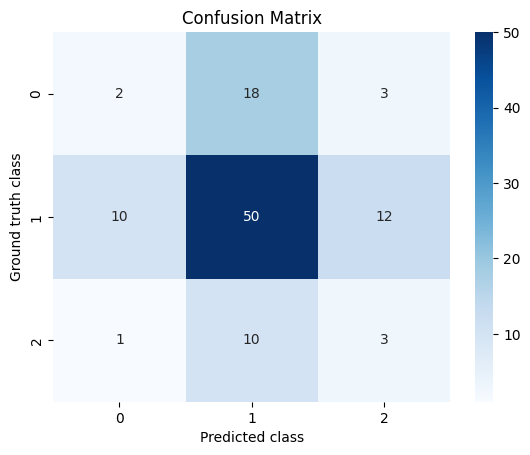

In [ ]:
yc_pred = net3_weight_correction.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Weight_CM/confusion_matrix_3.png')
plt.show()

In [ ]:
net3_weight_correction.save('gdrive/My Drive/Progetto DeepLearning/Model/net3_weight_correction.h5')

### Model 4

In [ ]:
# Base model

# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_weight_correction = keras.Model(inputs=inputs, outputs=outputs)


NameError: ignored

In [ ]:
# Compile the model for training
net4_weight_correction.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history4_weight_correction = net4_weight_correction.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/100
14/14 [==============================] - 112s 5s/step - loss: 6.4346 - accuracy: 0.4432 - precision_6: 0.4465 - val_loss: 3.1085 - val_accuracy: 0.3578 - val_precision_6: 0.3551
Epoch 2/100
14/14 [==============================] - 97s 5s/step - loss: 0.5520 - accuracy: 0.7409 - precision_6: 0.7413 - val_loss: 1.8481 - val_accuracy: 0.4771 - val_precision_6: 0.4811
Epoch 3/100
14/14 [==============================] - 96s 4s/step - loss: 0.2915 - accuracy: 0.8977 - precision_6: 0.9037 - val_loss: 4.5839 - val_accuracy: 0.3028 - val_precision_6: 0.3019
Epoch 4/100
14/14 [==============================] - 92s 4s/step - loss: 0.5563 - accuracy: 0.8068 - precision_6: 0.8059 - val_loss: 6.3512 - val_accuracy: 0.3303 - val_precision_6: 0.3241
Epoch 5/100
14/14 [==============================] - 97s 4s/step - loss: 0.1183 - accuracy: 0.9500 - precision_6: 0.9522 - val_loss: 2.1210 - val_accuracy: 0.6330 - val_precision_6: 0.6355
Epoch 6/100
14/14 [==============================] - 9

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['loss']) + 1)),
    y=history4_weight_correction.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['val_loss']) + 1)),
    y=history4_weight_correction.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['accuracy']) + 1)),
    y=history4_weight_correction.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['val_accuracy']) + 1)),
    y=history4_weight_correction.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['precision_6']) + 1)),
    y=history4_weight_correction.history['precision_6'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_weight_correction.history['val_precision_6']) + 1)),
    y=history4_weight_correction.history['val_precision_6'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net4_weight_correction.evaluate(val_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 28s 3s/step - loss: 2.2832 - accuracy: 0.6789 - precision_6: 0.6789


[2.2832322120666504, 0.6788991093635559, 0.6788991093635559]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4/4 [==============================] - 30s 2s/step


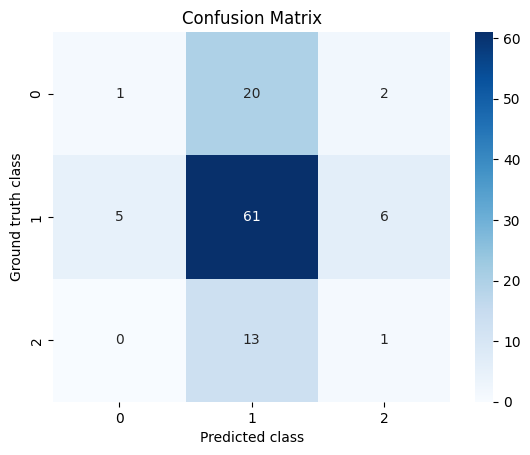

In [ ]:
yc_pred = net4_weight_correction.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Weight_CM/confusion_matrix_4.png')
plt.show()

In [ ]:
net4_weight_correction.save('gdrive/My Drive/Progetto DeepLearning/Model/net4_weight_correction.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Defining a model With Data Augmentation

### Model 1

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Data Augmentation
# Randomly flipping the input horizontally
x = keras.layers.RandomFlip(mode='horizontal')(x)
# Randomly adjusting the contrast of the input by a factor of 0.25
x = keras.layers.RandomContrast(0.25)(x)
# Randomly rotating the input by 10 degrees
x = keras.layers.RandomRotation(10)(x)
# Randomly zooming the input by a factor of 0.2
x = keras.layers.RandomZoom(0.2)(x)

# Adding a convolutional layer with 32 filters, kernel size of 3x3, and "same" padding
x = keras.layers.Conv2D(32, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters and a kernel size of 3x3
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying the "relu" activation function to the output of the convolutional layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Creating the model with the defined inputs and outputs
net1_data_augmentation = keras.Model(inputs, outputs)


<IPython.core.display.Javascript object>

In [ ]:
# Compile the model for training
net1_data_augmentation.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history1_data_augmentation = net1_data_augmentation.fit(train_dataset,
          #class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
14/14 [==============================] - 83s 3s/step - loss: 30.3197 - accuracy: 0.3136 - precision: 0.3136 - val_loss: 9.6787 - val_accuracy: 0.6514 - val_precision: 0.6514
Epoch 2/100
14/14 [==============================] - 74s 2s/step - loss: 11.8132 - accuracy: 0.3977 - precision: 0.3977 - val_loss: 7.5707 - val_accuracy: 0.3119 - val_precision: 0.3119
Epoch 3/100
14/14 [==============================] - 72s 3s/step - loss: 9.5493 - accuracy: 0.3523 - precision: 0.3539 - val_loss: 12.7647 - val_accuracy: 0.2294 - val_precision: 0.2294
Epoch 4/100
14/14 [==============================] - 60s 2s/step - loss: 6.0432 - accuracy: 0.3386 - precision: 0.3387 - val_loss: 11.6578 - val_accuracy: 0.1743 - val_precision: 0.1743
Epoch 5/100
14/14 [==============================] - 70s 3s/step - loss: 5.0818 - accuracy: 0.3568 - precision: 0.3568 - val_loss: 5.8550 - val_accuracy: 0.2202 - val_precision: 0.2150
Epoch 6/100
14/14 [==============================] - 63s 2s/step - loss

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['loss']) + 1)),
    y=history1_data_augmentation.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['val_loss']) + 1)),
    y=history1_data_augmentation.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['accuracy']) + 1)),
    y=history1_data_augmentation.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['val_accuracy']) + 1)),
    y=history1_data_augmentation.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['precision']) + 1)),
    y=history1_data_augmentation.history['precision'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1_data_augmentation.history['val_precision']) + 1)),
    y=history1_data_augmentation.history['val_precision'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


<IPython.core.display.Javascript object>

In [ ]:
net1_data_augmentation.evaluate(val_dataset)

<IPython.core.display.Javascript object>

4/4 [==============================] - 14s 16ms/step - loss: 1.4779 - accuracy: 0.4128 - precision: 0.4066


[1.4778555631637573, 0.4128440320491791, 0.4065934121608734]

<IPython.core.display.Javascript object>

4/4 [==============================] - 12s 14ms/step


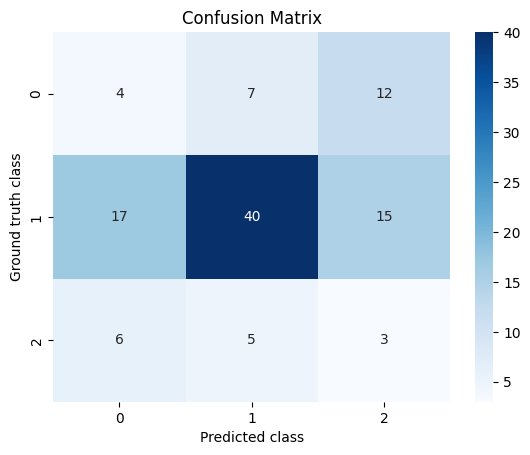

In [ ]:
yc_pred = net1_data_augmentation.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Data_Augmentation_CM/confusion_matrix_1.png')
plt.show()

In [ ]:
net1_data_augmentation.save('gdrive/My Drive/Progetto DeepLearning/Model/net1_data_augmentation.h5')

<IPython.core.display.Javascript object>

### Model 2

In [ ]:
# Architecture definition

# Defining the input of the model with dimensions 224x224 and 3 color channels (RGB)
inputs = keras.Input((224, 224, 3))

x = inputs

# Data Augmentation
# Randomly flipping the input horizontally
x = keras.layers.RandomFlip(mode='horizontal')(x)
# Randomly adjusting the contrast of the input by a factor of 0.25
x = keras.layers.RandomContrast(0.25)(x)
# Randomly rotating the input by 10 degrees
x = keras.layers.RandomRotation(10)(x)
# Randomly zooming the input by a factor of 0.2
x = keras.layers.RandomZoom(0.2)(x)

# Adding a convolutional layer with 32 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 64 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)
# Applying a MaxPooling layer with a pool size of 3x3, stride of 3, and "same" padding
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# Adding another convolutional layer with 128 filters, kernel size of 3x3, "same" padding,
# and L2 regularization with a factor of 0.001
x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# Adding batch normalization to normalize the activations of the previous layer
x = keras.layers.BatchNormalization()(x)
# Applying the "relu" activation function to the output of the previous layer
x = keras.layers.Activation("relu")(x)

# Applying a GlobalMaxPooling layer to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)

# Adding a fully connected layer with 64 units, "relu" activation,
# and L2 regularization with a factor of 0.001
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Adding a final fully connected layer with num_classes units, softmax activation,
# and L2 regularization with a factor of 0.001
outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# Creating the model with the defined inputs and outputs
net2_data_augmentation = keras.Model(inputs, outputs)


In [ ]:
# Compile the model for training
net2_data_augmentation.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

In [ ]:
# Model training
history2_data_augmentation = net2_data_augmentation.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

Epoch 1/100
28/28 [==============================] - 335s 7s/step - loss: 0.5723 - accuracy: 0.3682 - precision: 0.3499 - val_loss: 10.3255 - val_accuracy: 0.1142 - val_precision: 0.1142
Epoch 2/100
16/28 [================>.............] - ETA: 49s - loss: 0.4596 - accuracy: 0.4023 - precision: 0.4459

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-d9761cab9110>", line 2, in <cell line: 2>
    history2_data_augmentation = net2_data_augmentation.fit(train_dataset,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorfl

TypeError: ignored

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['loss']) + 1)),
    y=history2_data_augmentation.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['val_loss']) + 1)),
    y=history2_data_augmentation.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['accuracy']) + 1)),
    y=history2_data_augmentation.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['val_accuracy']) + 1)),
    y=history2_data_augmentation.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['precision_1']) + 1)),
    y=history2_data_augmentation.history['precision_1'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history2_data_augmentation.history['val_precision_1']) + 1)),
    y=history2_data_augmentation.history['val_precision_1'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [ ]:
net2_data_augmentation.evaluate(val_dataset)

<IPython.core.display.Javascript object>

4/4 [==============================] - 12s 24ms/step


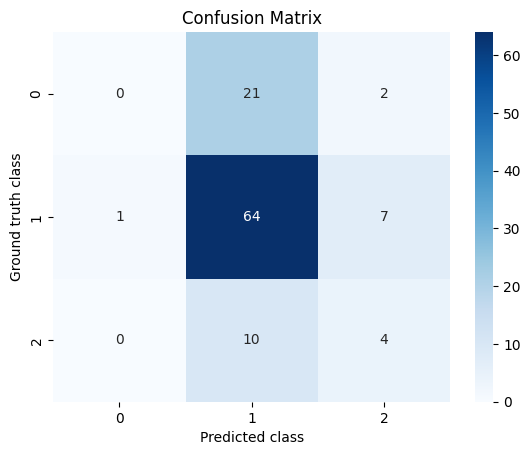

In [ ]:
yc_pred = net2_data_augmentation.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Data_Augmentation_CM/confusion_matrix_2.png')
plt.show()

In [ ]:
net2_data_augmentation.save('gdrive/My Drive/Progetto DeepLearning/Model/net2_data_augmentation.h5')

### Model 3

In [ ]:
# Base model

# Using the pre-trained ResNet50 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Data Augmentation
# Randomly flipping the input horizontally
x = keras.layers.RandomFlip(mode='horizontal')(x)
# Randomly adjusting the contrast of the input by a factor of 0.25
x = keras.layers.RandomContrast(0.25)(x)
# Randomly rotating the input by 10 degrees
x = keras.layers.RandomRotation(10)(x)
# Randomly zooming the input by a factor of 0.2
x = keras.layers.RandomZoom(0.2)(x)

# Preprocessing the input using the preprocessing function of ResNet50
x = keras.applications.resnet50.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net3_data_augmentation = keras.Model(inputs=inputs, outputs=outputs)


<IPython.core.display.Javascript object>

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Compile the model for training
net3_data_augmentation.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history3_data_augmentation = net3_data_augmentation.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
14/14 [==============================] - 77s 2s/step - loss: 10.9557 - accuracy: 0.3659 - precision_2: 0.3667 - val_loss: 3.1774 - val_accuracy: 0.5413 - val_precision_2: 0.5413
Epoch 2/100
14/14 [==============================] - 67s 3s/step - loss: 1.5636 - accuracy: 0.5136 - precision_2: 0.5150 - val_loss: 2.9767 - val_accuracy: 0.4495 - val_precision_2: 0.4444
Epoch 3/100
14/14 [==============================] - 61s 2s/step - loss: 1.6784 - accuracy: 0.5409 - precision_2: 0.5436 - val_loss: 2.8157 - val_accuracy: 0.5505 - val_precision_2: 0.5463
Epoch 4/100
14/14 [==============================] - 63s 2s/step - loss: 1.7667 - accuracy: 0.5523 - precision_2: 0.5517 - val_loss: 2.9275 - val_accuracy: 0.6055 - val_precision_2: 0.6111
Epoch 5/100
14/14 [==============================] - 66s 2s/step - loss: 1.5222 - accuracy: 0.5477 - precision_2: 0.5484 - val_loss: 3.7736 - val_accuracy: 0.5505 - val_precision_2: 0.5607
Epoch 6/100
14/14 [==============================] - 6

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['loss']) + 1)),
    y=history3_data_augmentation.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['val_loss']) + 1)),
    y=history3_data_augmentation.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['accuracy']) + 1)),
    y=history3_data_augmentation.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['val_accuracy']) + 1)),
    y=history3_data_augmentation.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['precision_2']) + 1)),
    y=history3_data_augmentation.history['precision_2'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history3_data_augmentation.history['val_precision_2']) + 1)),
    y=history3_data_augmentation.history['val_precision_2'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

<IPython.core.display.Javascript object>

In [ ]:
net3_data_augmentation.evaluate(val_dataset)

<IPython.core.display.Javascript object>

4/4 [==============================] - 14s 90ms/step - loss: 3.4512 - accuracy: 0.5872 - precision_2: 0.5833


[3.4511749744415283, 0.5871559381484985, 0.5833333134651184]

<IPython.core.display.Javascript object>

4/4 [==============================] - 14s 105ms/step


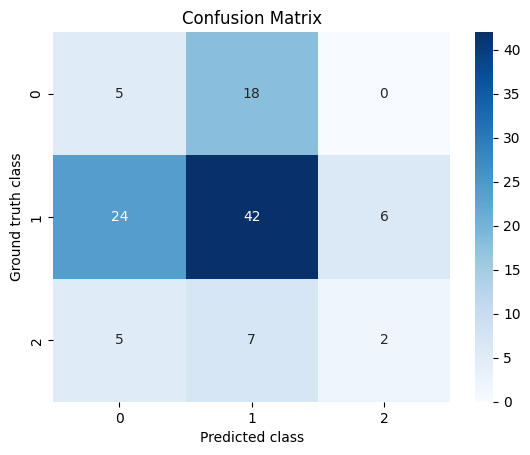

In [ ]:
yc_pred = net3_data_augmentation.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Data_Augmentation_CM/confusion_matrix_3.png')
plt.show()

In [ ]:
net3_data_augmentation.save('gdrive/My Drive/Progetto DeepLearning/Model/net3_data_augmentation.h5')

<IPython.core.display.Javascript object>

### Model 4

In [ ]:
# Base model

# Using the pre-trained MobileNetV2 model as the base model with input shape (224, 224, 3)
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
# Freezing the weights of the base model to prevent them from being updated during training
base_net.trainable = False

# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Data Augmentation
# Randomly flipping the input horizontally
x = keras.layers.RandomFlip(mode='horizontal')(x)
# Randomly adjusting the contrast of the input by a factor of 0.25
x = keras.layers.RandomContrast(0.25)(x)
# Randomly rotating the input by 10 degrees
x = keras.layers.RandomRotation(10)(x)
# Randomly zooming the input by a factor of 0.2
x = keras.layers.RandomZoom(0.2)(x)

# Preprocessing the input using the preprocessing function of MobileNetV2
x = keras.applications.mobilenet_v2.preprocess_input(x)
# Passing the preprocessed input through the base model
x = base_net(x)
# Adding a convolutional layer with 64 filters and kernel size of 3x3 to further process the features
x = keras.layers.Conv2D(64, 3, padding="same")(x)
# Applying GlobalMaxPooling to reduce the spatial dimensions
x = keras.layers.GlobalMaxPooling2D()(x)
# Adding a dense layer with softmax activation for the final classification
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

# Creating the specialized model by defining the inputs and outputs
net4_data_augmentation = keras.Model(inputs=inputs, outputs=outputs)


<IPython.core.display.Javascript object>

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Compile the model for training
net4_data_augmentation.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy', keras.metrics.Precision()])

<IPython.core.display.Javascript object>

In [ ]:
# Model training
history4_data_augmentation = net4_data_augmentation.fit(train_dataset,
          class_weight=train_class_weights,
          epochs=100,
          validation_data=val_dataset,
          callbacks=[callback]);

<IPython.core.display.Javascript object>

Epoch 1/100
14/14 [==============================] - 72s 2s/step - loss: 9.7426 - accuracy: 0.4091 - precision_4: 0.4066 - val_loss: 1.4470 - val_accuracy: 0.5963 - val_precision_4: 0.6078
Epoch 2/100
14/14 [==============================] - 68s 3s/step - loss: 0.7326 - accuracy: 0.5250 - precision_4: 0.5403 - val_loss: 1.6099 - val_accuracy: 0.5413 - val_precision_4: 0.5413
Epoch 3/100
14/14 [==============================] - 60s 2s/step - loss: 0.8299 - accuracy: 0.5295 - precision_4: 0.5436 - val_loss: 1.4876 - val_accuracy: 0.6239 - val_precision_4: 0.6262
Epoch 4/100
14/14 [==============================] - 66s 2s/step - loss: 0.8817 - accuracy: 0.5705 - precision_4: 0.5793 - val_loss: 1.2675 - val_accuracy: 0.6514 - val_precision_4: 0.6604
Epoch 5/100
14/14 [==============================] - 60s 2s/step - loss: 0.8424 - accuracy: 0.5409 - precision_4: 0.5459 - val_loss: 2.2217 - val_accuracy: 0.3486 - val_precision_4: 0.3585
Epoch 6/100
14/14 [==============================] - 70

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['loss']) + 1)),
    y=history4_data_augmentation.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['val_loss']) + 1)),
    y=history4_data_augmentation.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['accuracy']) + 1)),
    y=history4_data_augmentation.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['val_accuracy']) + 1)),
    y=history4_data_augmentation.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()
# Grafico Precision

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['precision_4']) + 1)),
    y=history4_data_augmentation.history['precision_4'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history4_data_augmentation.history['val_precision_4']) + 1)),
    y=history4_data_augmentation.history['val_precision_4'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation precision',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='precision'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()



<IPython.core.display.Javascript object>

In [ ]:
net4_data_augmentation.evaluate(val_dataset)

<IPython.core.display.Javascript object>

4/4 [==============================] - 13s 48ms/step - loss: 1.8106 - accuracy: 0.5688 - precision_4: 0.5741


[1.8105806112289429, 0.5688073635101318, 0.5740740895271301]

<IPython.core.display.Javascript object>

4/4 [==============================] - 13s 50ms/step


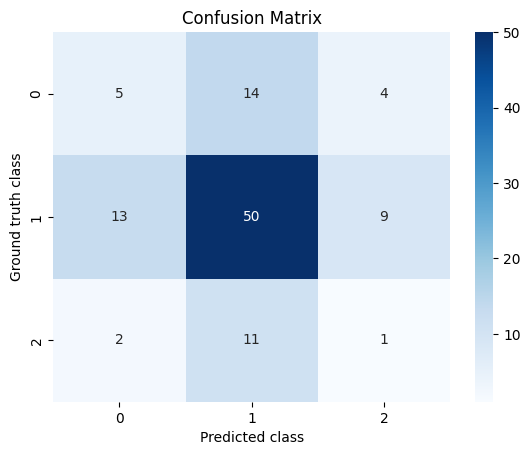

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

yc_pred = net4_data_augmentation.predict(val_dataset)
y_pred = np.argmax(yc_pred, axis=1)
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')
plt.title('Confusion Matrix')
plt.savefig('gdrive/My Drive/Progetto DeepLearning/Imm/Data_Augmentation_CM/confusion_matrix_4.png')  # Salva l'immagine come 'confusion_matrix.png'
plt.show()

In [ ]:
net4_data_augmentation.save('gdrive/My Drive/Progetto DeepLearning/Model/net4_data_augmentation.h5')

<IPython.core.display.Javascript object>

NameError: ignored

# Model evaluation (First Model)

In [ ]:
net = keras.models.load_model('gdrive/My Drive/Progetto DeepLearning/Model_20%/net4_without_balancing.h5')

<IPython.core.display.Javascript object>

In [ ]:
'''
# Assign label names to the corresponding indexes

labels = {
    0: 'nevus',
    1: 'melanoma',
    2: 'seborrheic_keratosis'
}

# Load images and their predictions
import PIL
prediction = []
original = []
image = []
count = 0
for i in os.listdir(base_path):
    for item in os.listdir(os.path.join(base_path, i))[:10]:#takes the first 10 images for each label
        # code to open the image
        img= PIL.Image.open(os.path.join(base_path, i, item))
        # resizing the image to (224,224)
        img = img.resize((224, 224))
        # appending image to the image list
        image.append(img)
        # converting image to array
        img = np.asarray(img, dtype = np.float32)
        # normalizing the image
        img = img / 255
        # reshaping the image into a 4D array
        img = img.reshape(-1, 224, 224, 3)
        # making prediction of the model
        predict = net.predict(img)
        # getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        # appending the predicted class to the list
        prediction.append(labels[predict])
        # appending original class to the list
        original.append(i)
'''

<IPython.core.display.Javascript object>

"\n# Assign label names to the corresponding indexes\n\nlabels = {\n    0: 'nevus',\n    1: 'melanoma',\n    2: 'seborrheic_keratosis'\n}\n\n# Load images and their predictions\nimport PIL\nprediction = []\noriginal = []\nimage = []\ncount = 0\nfor i in os.listdir(base_path):\n    for item in os.listdir(os.path.join(base_path, i))[:10]:#takes the first 10 images for each label\n        # code to open the image\n        img= PIL.Image.open(os.path.join(base_path, i, item))\n        # resizing the image to (224,224)\n        img = img.resize((224, 224))\n        # appending image to the image list\n        image.append(img)\n        # converting image to array\n        img = np.asarray(img, dtype = np.float32)\n        # normalizing the image\n        img = img / 255\n        # reshaping the image into a 4D array\n        img = img.reshape(-1, 224, 224, 3)\n        # making prediction of the model\n        predict = net.predict(img)\n        # getting the index corresponding to the highe

In [ ]:
# Visualize the results at random
'''
fig = plt.figure(figsize = (100,100))
j_li=[]
for i in range(10):
    j = random.randint(0, len(image))
    j_li.append(j)
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])

fig.tight_layout()
plt.show()
'''

<IPython.core.display.Javascript object>

'\nfig = plt.figure(figsize = (100,100))\nj_li=[]\nfor i in range(10):\n    j = random.randint(0, len(image))\n    j_li.append(j)\n    fig.add_subplot(20, 1, i+1)\n    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])\n    plt.imshow(image[j])\n\nfig.tight_layout()\nplt.show()\n'

In [ ]:
import PIL
import numpy as np

'''
labels = {
    0: 'melanoma',
    1: 'seborrheic_keratosis',
    2: 'nevus'
}
'''
labels = {
    0: 'nevus',
    1: 'melanoma',
    2: 'seborrheic_keratosis'
}

# Insert the image path here
image_path = 'gdrive/My Drive/Progetto DeepLearning/Prova/melanoma/ISIC_0000004.jpg'

# Load the image and its prediction
prediction = []
original = []
image = []

# Open the image
img = PIL.Image.open(image_path)
# Resize the image to (224, 224)
img = img.resize((224, 224))
# Add the image to the image list
image.append(img)
# Convert the image to an array
img_array = np.asarray(img, dtype=np.float32)
# Normalize the image
img_array = img_array / 223
# Reshape the image array to a 4D array
img_array = img_array.reshape(-1, 224, 224, 3)
# Make predictions on the image using the model
predict = net.predict(img_array)
# Get the index corresponding to the highest value in the prediction
predict = np.argmax(predict)
# Add the predicted class to the prediction list
prediction.append(labels[predict])
# Add the original class to the original class list
original.append('melanoma')  # You can specify an original class if you know it

# Print the predictions and original classes
for pred, orig in zip(prediction, original):
    print(f"Prediction: {pred}")
    print(f"Original Class: {orig}")

<IPython.core.display.Javascript object>

1/1 [==============================] - 10s 10s/step
Prediction: melanoma
Original Class: melanoma


<IPython.core.display.Javascript object>

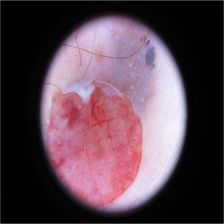

In [ ]:
image[0]

# Explainable AI

## Lime

In [ ]:
pip install lime

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=afd4a2dc77b8a856e7c05f7c569a55c4f16383c5730a26231cfb35902152d3b1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
def transform_img_fn(path_list):
    # Initialize an empty list to store the transformed images
    out = []

    # Iterate over each image path in the path_list
    for img_path in path_list:
        # Load the image and resize it to the target size of (224, 224)
        img = im.load_img(img_path, target_size=(224, 224))

        # Convert the image to an array
        x = im.img_to_array(img)

        # Expand the dimensions of the image array to match the expected input shape
        x = np.expand_dims(x, axis=0)

        # Preprocess the image according to the requirements of the inc_net model
        x = inc_net.preprocess_input(x)

        # Append the preprocessed image to the output list
        out.append(x)

    # Stack the preprocessed images vertically to create a single array
    return np.vstack(out)

# Transform the image using the transform_img_fn function
# by providing the image path as a list
images = transform_img_fn([os.path.join('gdrive/My Drive/Progetto DeepLearning/Prova/melanoma/','ISIC_0000002.jpg')])


<IPython.core.display.Javascript object>

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), net.predict, top_labels=5, hide_color=0, num_samples=1000)

<IPython.core.display.Javascript object>

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 536ms/step


<IPython.core.display.Javascript object>

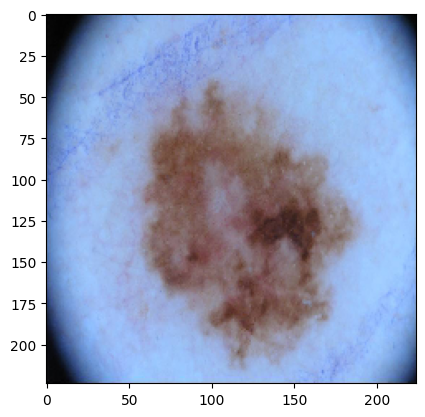

In [ ]:
plt.imshow(images[0] / 2 + 0.5)

<IPython.core.display.Javascript object>

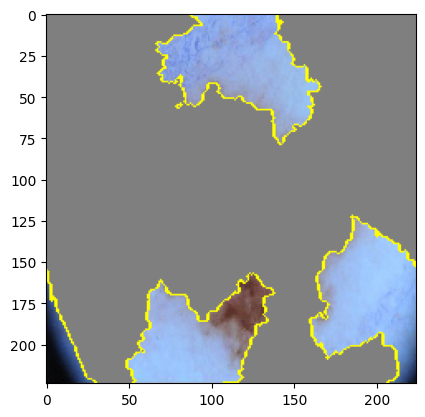

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

<IPython.core.display.Javascript object>

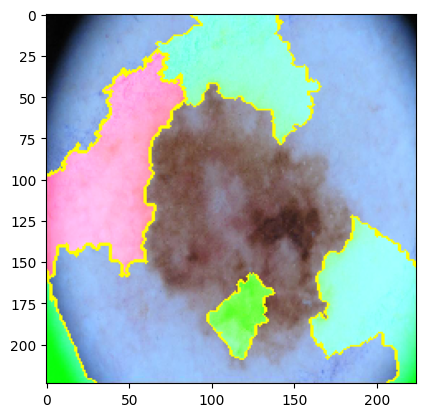

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Grad Cam

In [ ]:
net.summary()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          737344    
                                                           

In [ ]:
def grad_cam(img):
    # Convert the image to array of type float32
    img = np.asarray(img, dtype = np.float32)

    # Reshape the image from (224,224,3) to (1,224,224,3)
    img = img.reshape(-1, 224, 224, 3)
    img_scaled = img / 223

    # Name of the average pooling layer and dense final (you can see these names in the model summary)
    classification_layers = ["global_max_pooling2d_2", "dense_1"]

    # Last convolutional layer in the model
    final_conv = net.get_layer("conv2d_2")

    # Create a model with original model inputs and the last conv_layer as the output
    final_conv_model = keras.Model(net.inputs, final_conv.output)

    # Then we create the input for classification layer, which is the output of last conv layer
    # In our case, output produced by the conv layer is of the shape (1,3,3,2048)
    # Since the classification input needs the features as input, we ignore the batch dimension

    classification_input = keras.Input(shape = final_conv.output.shape[1:])

    # We iterate through the classification layers, to get the final layer and then append
    # the layer as the output layer to the classification model.
    temp = classification_input
    for layer in classification_layers:
        temp = net.get_layer(layer)(temp)

    classification_model = keras.Model(classification_input, temp)


    # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
    # corresponding to the predicted class
    with tf.GradientTape() as tape:
        # Pass the image through the base model and get the feature map
        final_conv_output = final_conv_model(img_scaled)

        # Assign gradient tape to monitor the conv_output
        tape.watch(final_conv_output)

        prediction = classification_model(final_conv_output)
        predicted_class = tf.argmax(prediction, axis=-1)
        predicted_class_value = tf.reduce_max(prediction, axis=-1)

    # Get the gradient corresponding to the predicted class based on feature map.
    gradient = tape.gradient(predicted_class_value, final_conv_output)

    # Since we need the filter values, we reduce the other dimensions,
    gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

    # We then convert the feature map produced by last conv layer
    final_conv_output = final_conv_output.numpy()[0]

    gradient_channels = gradient_channels.numpy()

    # We multiply the filters in the feature map produced by final conv layer by the
    # filter values that are used to get the predicted class. By doing this we inrease the
    # value of areas that helped in making the prediction and lower the vlaue of areas, that
    # did not contribute towards the final prediction
    for i in range(gradient_channels.shape[-1]):
        final_conv_output[:, :, i] *= gradient_channels[i]

    # We take the mean accross the channels to get the feature map
    heatmap = np.mean(final_conv_output, axis=-1)

    # Normalizing the heat map between 0 and 1, to visualize it
    heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

    # Rescaling and converting the type to int
    heatmap = np.uint8(223 * heatmap_normalized )

    # Create the colormap
    color_map = plt.cm.get_cmap('jet')

    # get only the rb features from the heatmap
    color_map = color_map(np.arange(224))[:, :3]
    heatmap = color_map[heatmap]

    # convert the array to image, resize the image and then convert to array
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((224, 224))
    heatmap = np.asarray(heatmap, dtype = np.float32)

    # Add the heatmap on top of the original image
    final_img = heatmap * 0.4 + img[0]
    final_img = keras.preprocessing.image.array_to_img(final_img)

    return final_img, heatmap_normalized

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-54-204a1d0cad70>:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('jet')


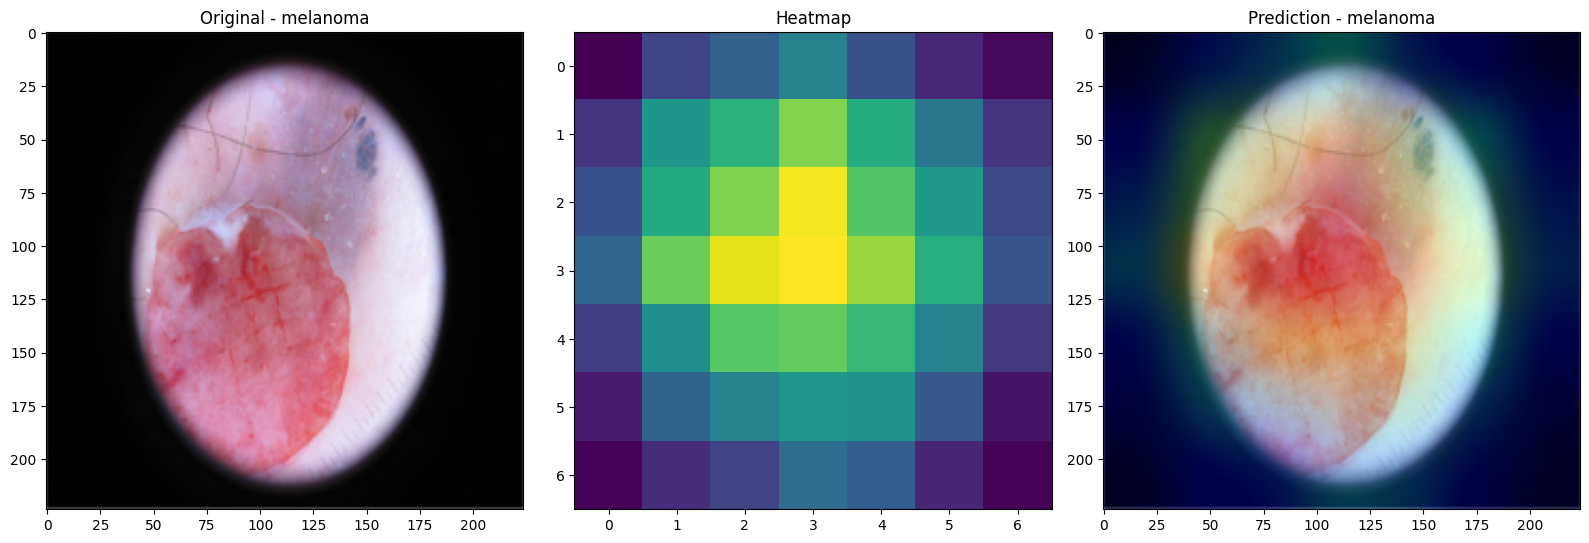

In [ ]:
# Generate Grad-CAM and the heat map for the selected image
gradcam, heatmap = grad_cam(image[0])

# Create the figure and axes for visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Display the original image
axs[0].set_title("Original - " + original[0])
axs[0].imshow(image[0])

# Display the heat map
axs[1].set_title("Heatmap")
axs[1].imshow(heatmap)

# Display the prediction
axs[2].set_title("Prediction - " + prediction[0])
axs[2].imshow(gradcam)

# Adjust the layout of the axes in the figure
fig.tight_layout()

# Show the figure
plt.show()


In [ ]:
# Visualize the images in the dataset
'''
fig, axs = plt.subplots(6,3, figsize = (16,32))
count = 0
for _ in range(6):
    i = random.randint(0, len(image))
    gradcam, heatmap = grad_cam(image[i])
    axs[count][0].title.set_text("Original -" + original[i])
    axs[count][0].imshow(image[i])
    axs[count][1].title.set_text("Heatmap")
    axs[count][1].imshow(heatmap)
    axs[count][2].title.set_text("Prediction -" + prediction[i])
    axs[count][2].imshow(gradcam)
    count += 1

fig.tight_layout()
'''

<IPython.core.display.Javascript object>

'\nfig, axs = plt.subplots(6,3, figsize = (16,32))\ncount = 0\nfor _ in range(6):\n    i = random.randint(0, len(image))\n    gradcam, heatmap = grad_cam(image[i])\n    axs[count][0].title.set_text("Original -" + original[i])\n    axs[count][0].imshow(image[i])\n    axs[count][1].title.set_text("Heatmap")\n    axs[count][1].imshow(heatmap)\n    axs[count][2].title.set_text("Prediction -" + prediction[i])\n    axs[count][2].imshow(gradcam)\n    count += 1\n\nfig.tight_layout()\n'

In [ ]:
import keras
from PIL import Image

model_builder = net
img_size = (224, 224)
preprocess_input = keras.applications.mobilenet_v2.preprocess_input
decode_predictions = keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "conv2d_2"

img_path = "gdrive/My Drive/Progetto DeepLearning/Data/nevus/ISIC_0016069.jpg"

image = Image.open(img_path)


<IPython.core.display.Javascript object>

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 31ms/step


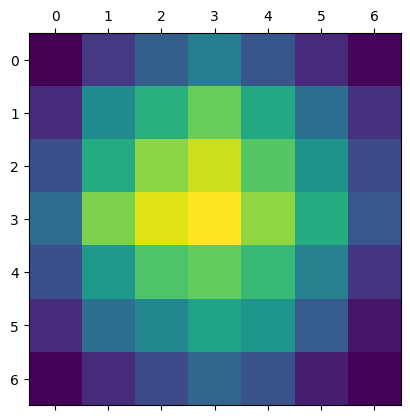

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = net

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()